In [1]:
# Функция для расчета скользящих средних
def calculate_moving_averages(data, window):
    data['SMA_' + str(window)] = data['Цена'].rolling(window=window).mean()  # Простое скользящее среднее
    data['EMA_' + str(window)] = data['Цена'].ewm(span=window, adjust=False).mean()  # Экспоненциальное скользящее среднее
    return data
# Функция для расчета RSI
def calculate_rsi(data, window=14):
    delta = data['Цена'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi
    return data

# Функция для расчета MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Цена'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Цена'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = short_ema - long_ema
    data['Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    return data

def create_dataset(dataset, time_steps=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_steps-1):
        a = dataset[i:(i+time_steps), :]
        dataX.append(a)
        dataY.append(dataset[i + time_steps, -1])  # Assuming 'Цена' is the last column
    return np.array(dataX), np.array(dataY)

In [2]:
import tensorflow

C:\Users\User\anaconda3\envs\models_checking\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
# Загрузка данных
data_lkoh = pd.read_csv('data/Прошлые данные - INGR.csv')
# Убираем суффиксы "K" из столбца "Объём"
data_lkoh['Объём'] = data_lkoh['Объём'].str.replace('M', '000000').str.replace('K', '000')

data_lkoh['Изм. %'] = data_lkoh['Изм. %'].str.replace('%', '')

# Преобразование типов данных с учетом разделителей тысяч и возможных десятичных запятых
data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])
data_lkoh['Цена'] = pd.to_numeric(data_lkoh['Цена'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Откр.'] = pd.to_numeric(data_lkoh['Откр.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Макс.'] = pd.to_numeric(data_lkoh['Макс.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Мин.'] = pd.to_numeric(data_lkoh['Мин.'].str.replace('.', '').str.replace(',', '.'))
data_lkoh['Объём'] = pd.to_numeric(data_lkoh['Объём'].str.replace('.', '').str.replace(',', ''))
data_lkoh['Изм. %'] = pd.to_numeric(data_lkoh['Изм. %'].str.replace(',', '.'))

df = data_lkoh
df['dayofweek'] = df['Дата'].dt.dayofweek
df['quarter'] = df['Дата'].dt.quarter
df['month'] = df['Дата'].dt.month
df['year'] = df['Дата'].dt.year
df['dayofyear'] = df['Дата'].dt.dayofyear
df['dayofmonth'] = df['Дата'].dt.day
df['weekofyear'] = df['Дата'].dt.isocalendar().week
# Выберите начальную дату (например, первая дата в вашем наборе данных)
start_date = data_lkoh['Дата'].min()

# Рассчитайте количество дней от начальной даты для каждой строки
data_lkoh['timestamp'] = (data_lkoh['Дата'] - start_date).dt.days

# Расчет признаков
data_lkoh = calculate_moving_averages(data_lkoh, window=20)  # Пример: 20-дневные скользящие средние
data_lkoh = calculate_rsi(data_lkoh)
data_lkoh = calculate_macd(data_lkoh)
# Interpolate missing values for 'RSI' and 'SMA_20' columns
data_lkoh['RSI'].interpolate(inplace=True)
data_lkoh['SMA_20'].interpolate(inplace=True)

# Check for remaining missing values
missing_values = data_lkoh.isnull().sum()
missing_values

C:\Users\User\AppData\Local\Temp\ipykernel_1428\2849261429.py:23: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data_lkoh['Дата'] = pd.to_datetime(data_lkoh['Дата'])


Дата            0
Цена            0
Откр.           0
Макс.           0
Мин.            0
Объём           0
Изм. %          0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
weekofyear      0
timestamp       0
SMA_20         19
EMA_20          0
RSI            13
MACD            0
Signal_Line     0
dtype: int64

In [4]:
data_lkoh = data_lkoh.sort_index(ascending=False)
data_lkoh = data_lkoh.reset_index(drop=True)
data_lkoh



        Дата   Цена  Откр.  Макс.   Мин.   Объём  Изм. %  dayofweek  quarter  \
0 2013-01-14  314.3  302.0  325.9  285.5  133000    2.48          0        1   
1 2013-01-15  315.4  314.0  320.2  310.0   57000    0.35          1        1   
2 2013-01-16  325.5  316.9  336.0  315.0  319000    3.20          2        1   
3 2013-01-17  318.0  338.7  338.7  315.4   73000   -2.30          3        1   
4 2013-01-18  322.7  319.7  324.0  315.6   35000    1.48          4        1   

   month  ...  dayofyear  dayofmonth  weekofyear  timestamp   SMA_20  \
0      1  ...         14          14           3          0  316.410   
1      1  ...         15          15           3          1  318.395   
2      1  ...         16          16           3          2  321.125   
3      1  ...         17          17           3          3  323.735   
4      1  ...         18          18           3          4  325.725   

       EMA_20        RSI      MACD  Signal_Line  Target  
0  321.089981  59.509202 -3.

In [12]:
data = pd.DataFrame(data)

# Save X_train, X_test, y_train_df, and y_test_df to Parquet files
data.to_parquet('data/data.parquet')

C:\Users\User\AppData\Local\Temp\ipykernel_1428\3658020941.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = scaler.fit_transform(data['Target'].values.reshape(-1, 1))


2126


C:\Users\User\AppData\Local\Temp\ipykernel_14544\3964106193.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = scaler.fit_transform(data['Target'].values.reshape(-1, 1))


2126
Epoch 1/5
2126/2126 [==============================] - 40s 17ms/step - loss: 0.0029 - val_loss: 0.0812
Epoch 2/5
2126/2126 [==============================] - 38s 18ms/step - loss: 0.0019 - val_loss: 6.4318e-04
Epoch 3/5
 116/2126 [>.............................] - ETA: 26s - loss: 9.1445e-04


KeyboardInterrupt



In [296]:

# # Подготовка данных для XGBoost
# X = data_lkoh[[ 'dayofweek', 'quarter', 'month', 'year',
#                 'dayofyear', 'dayofmonth', 'weekofyear','timestamp',]]
X = data_lkoh.drop(['Target','Дата'],axis=1)
y = data_lkoh['Target']  # Целевая переменная


X = X[-len(X_ltsm):]
y = y[-len(X_ltsm):]


# Разделение данных на обучающую и тестовую выборки
X_train,X_test = X[:train_size], X[train_size:]
y_train,y_test = y[:train_size], y[train_size:]
from sklearn.preprocessing import StandardScaler
# 
# # Инициализация scaler
# scaler = StandardScaler()
# 
# # Нормализация данных
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# Убедитесь, что X_test и X_test_lstm имеют одинаковое количество строк

# Убедитесь, что y_test и y_test_lstm имеют одинаковое количество строк

In [298]:
import pandas as pd

# Convert y_train and y_test to DataFrame objects
y_train_df = pd.DataFrame(y_train)
y_test_df = pd.DataFrame(y_test)

# Save X_train, X_test, y_train_df, and y_test_df to Parquet files
X_train.to_parquet('data/X_train.parquet')
X_test.to_parquet('data/X_test.parquet')
y_train_df.to_parquet('data/y_train.parquet')
y_test_df.to_parquet('data/y_test.parquet')

In [289]:
params = {
    'tree_method': 'hist',
    'device': 'cuda',
    'max_depth': 4,
    'n_estimators': 1100,
    'learning_rate': 0.2683229089980892,
    'subsample': 0.9,
    'gamma': 0.16553627228872347,
    'min_child_weight': 0.999734816446258,
    'max_delta_step': 0.32058180713235257,
    'colsample_bytree': 0.6664839820394654,
    'reg_alpha': 0.032217023806391465,
    'reg_lambda': 0.0010841335583071654,
    'scale_pos_weight': 0.2122327545777681
}

# Create the XGBoost model

In [ ]:

# Создание и обучение модели XGBoost
# model_xgb = xgb.XGBRegressor(max_depth=3, n_estimators=50, learning_rate = 0.5, gamma=0.6, alpha=0.2, reg_lambda=0.2,tree_method='hist',device = 'cuda')  # Подберите параметры по необходимости
model_xgb = xgb.XGBRegressor(**params)  # Подберите параметры по необходимости
model_xgb.fit(X_train, y_train)

# Прогнозирование
xgb_predictions_train = model_xgb.predict(X_train)


# Create and train the Random Forest model
model_rf = RandomForestRegressor(max_depth=3, n_estimators=200,max_features= 'log2' )  # Adjust the parameters as needed
model_rf.fit(X_train, y_train)

# Predict
rf_predictions_train = model_rf.predict(X_train)

import numpy as np

ensemble_features_train = np.column_stack(( np.squeeze(predictions_LTSM_train),xgb_predictions_train, rf_predictions_train))


xgboost_ensemble_model = xgb.XGBRegressor(max_depth=3, n_estimators=50, gamma=0.6, alpha=0.2, reg_lambda=0.2, learning_rate = 0.5)
xgboost_ensemble_model.fit(ensemble_features_train, y_train)

In [41]:
initial_actual_price = X_train_LTSM[-1]
initial_conditions = X_train_LTSM[-1]

current_price = initial_actual_price
predicted_price = initial_actual_price

num_days = len(X_test)
data = {
    'predicted_price': predicted_price.flatten()
}
predicted_price_df = pd.DataFrame(columns=['predicted_price'])
X_train_LTSM_models = X_train_LTSM

num_shares = 200
cash = 1000000

buy_and_hold_shares = num_shares
buy_and_hold_cash = cash
y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index(drop=True)
for day in range(num_days):
    predicted_price = model.predict(np.array([initial_conditions]))
    initial_conditions = np.concatenate((initial_conditions[1:], predicted_price), axis=0)

    current_price = np.array([y_test_LTSM[day]])

    updated_last_point = np.concatenate((initial_conditions[-1][1:], np.array([current_price[0]])), axis=0)
    initial_conditions[-1] = updated_last_point
    predicted_price_df = pd.concat([predicted_price_df, pd.DataFrame({'predicted_price': [predicted_price.flatten()[0]]})], ignore_index=True)

    zxc = pd.DataFrame(X_test.iloc[day]).transpose()
    xgb_predictions_test = model_xgb.predict(zxc)
    rf_predictions_test = model_rf.predict(zxc)
    predictions_inverted = scaler.inverse_transform(predicted_price.reshape(-1, 1))
    ensemble_features_test = np.column_stack((np.squeeze(predictions_inverted), xgb_predictions_test, rf_predictions_test))
    xgboost_ensemble_model_pred = xgboost_ensemble_model.predict(ensemble_features_test)
    predicted_price = xgboost_ensemble_model_pred
  
    current_price = y_test['Target'][day]

    if current_price < predicted_price.flatten()[0]:
        if cash >= current_price:
            num_shares += 1
            cash -= current_price
            print("Bought 1 share")
    elif current_price > predicted_price.flatten()[0]:
        if num_shares >= 1:
            num_shares -= 1
            cash += current_price
            print("Sold 1 share")

    buy_and_hold_cash = current_price * buy_and_hold_shares+1000000

print(f"Final number of shares: {num_shares}")
print(f"Final cash balance: {cash}")
cash = cash + current_price*num_shares
profit_strategy = cash - buy_and_hold_cash
profit_strategy_2 = cash/buy_and_hold_cash
print(f"Profit of the strategy: {profit_strategy}")
print(f"Profit of the strategy%: {profit_strategy_2}")

1/1 [==============================] - 0s 26ms/step
Bought 1 share
1/1 [==============================] - 0s 44ms/step
Bought 1 share
1/1 [==============================] - 0s 49ms/step
Bought 1 share
1/1 [==============================] - 0s 48ms/step
Bought 1 share
1/1 [==============================] - 0s 49ms/step
Bought 1 share
1/1 [==============================] - 0s 50ms/step
Bought 1 share
1/1 [==============================] - 0s 46ms/step
Sold 1 share
1/1 [==============================] - 0s 44ms/step
Sold 1 share
1/1 [==============================] - 0s 45ms/step
Sold 1 share
1/1 [==============================] - 0s 44ms/step
Sold 1 share
1/1 [==============================] - 0s 48ms/step
Sold 1 share
1/1 [==============================] - 0s 50ms/step
Sold 1 share
1/1 [==============================] - 0s 46ms/step
Bought 1 share
1/1 [==============================] - 0s 46ms/step
Bought 1 share
1/1 [==============================] - 0s 47ms/step
Bought 1 share
1/1 [==

ТЕСТЫ

ValueError: non-broadcastable output operand with shape (471,1) doesn't match the broadcast shape (471,16)

RMSE (Root Mean Squared Error): 173.54195885815327
r2 (Root Mean Squared Error): 0.30097344201139364
RMSE (Root Mean Squared Error): 267.0322137253337
r2 (Root Mean Squared Error): -0.6550533508184908


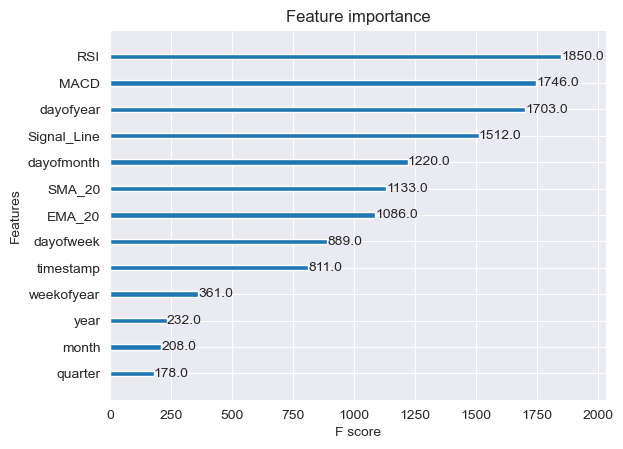

In [293]:
ensemble_features_test = np.column_stack(( np.squeeze(predictions_LTSM_test),xgb_predictions_test, rf_predictions_test))
xgboost_ensemble_model_pred = xgboost_ensemble_model.predict(ensemble_features_test)

# Рассчет метрик
mse = mean_squared_error(y_test, xgboost_ensemble_model_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xgboost_ensemble_model_pred)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)

RMSE (Root Mean Squared Error): 172.30195535988892
r2 (Root Mean Squared Error): 0.3109272150481762


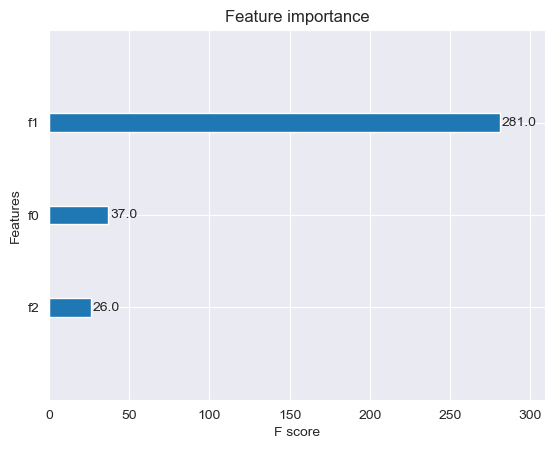

In [294]:
xgb.plot_importance(xgboost_ensemble_model)
plt.show()

In [238]:
from sklearn.ensemble import RandomForestRegressor

# Create the ensemble features array
ensemble_features_test = np.column_stack((np.squeeze(predictions_LTSM_test), xgb_predictions_test, rf_predictions_test))

# Create the Random Forest ensemble model
random_forest_ensemble_model = RandomForestRegressor(max_depth=3, n_estimators=200)
random_forest_ensemble_model.fit(ensemble_features_train, y_train)

# Make predictions using the Random Forest ensemble model
random_forest_ensemble_model_pred = random_forest_ensemble_model.predict(ensemble_features_test)

# Calculate metrics
mse = mean_squared_error(y_test, random_forest_ensemble_model_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, random_forest_ensemble_model_pred)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)

RMSE (Root Mean Squared Error): 169.12611146367553
r2 (Root Mean Squared Error): 0.33609488742885063


In [115]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# Create the ensemble features array
ensemble_features_test = np.column_stack((np.squeeze(predictions_LTSM_test), xgb_predictions_test, rf_predictions_test))

# Create the Bagging ensemble model with Random Forest as the base estimator
bagging_ensemble_model = BaggingRegressor(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_estimators=10, random_state=42)
bagging_ensemble_model.fit(ensemble_features_train, y_train)

# Make predictions using the Bagging ensemble model
bagging_ensemble_model_pred = bagging_ensemble_model.predict(ensemble_features_test)

# Calculate metrics
mse = mean_squared_error(y_test, bagging_ensemble_model_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, bagging_ensemble_model_pred)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)

RMSE (Root Mean Squared Error): 129.9365364289294
r2 (Root Mean Squared Error): 0.6081252710321071


In [239]:
import numpy as np

# Define the weights for each model
lstm_weight = 0.8
xgb_weight = 0.1
rf_weight = 0.1

# Create the ensemble features array
ensemble_features_test = np.column_stack((np.squeeze(predictions_LTSM_test), xgb_predictions_test, rf_predictions_test))

# Calculate the weighted average predictions
weighted_average_pred = (lstm_weight * np.squeeze(predictions_LTSM_test)) + (xgb_weight * xgb_predictions_test) + (rf_weight * rf_predictions_test)

# Calculate metrics
mse = mean_squared_error(y_test, weighted_average_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, weighted_average_pred)

print('RMSE (Root Mean Squared Error):', rmse)
print('r2 (Root Mean Squared Error):', r2)

RMSE (Root Mean Squared Error): 75.59583700105587
r2 (Root Mean Squared Error): 0.8673581881807164


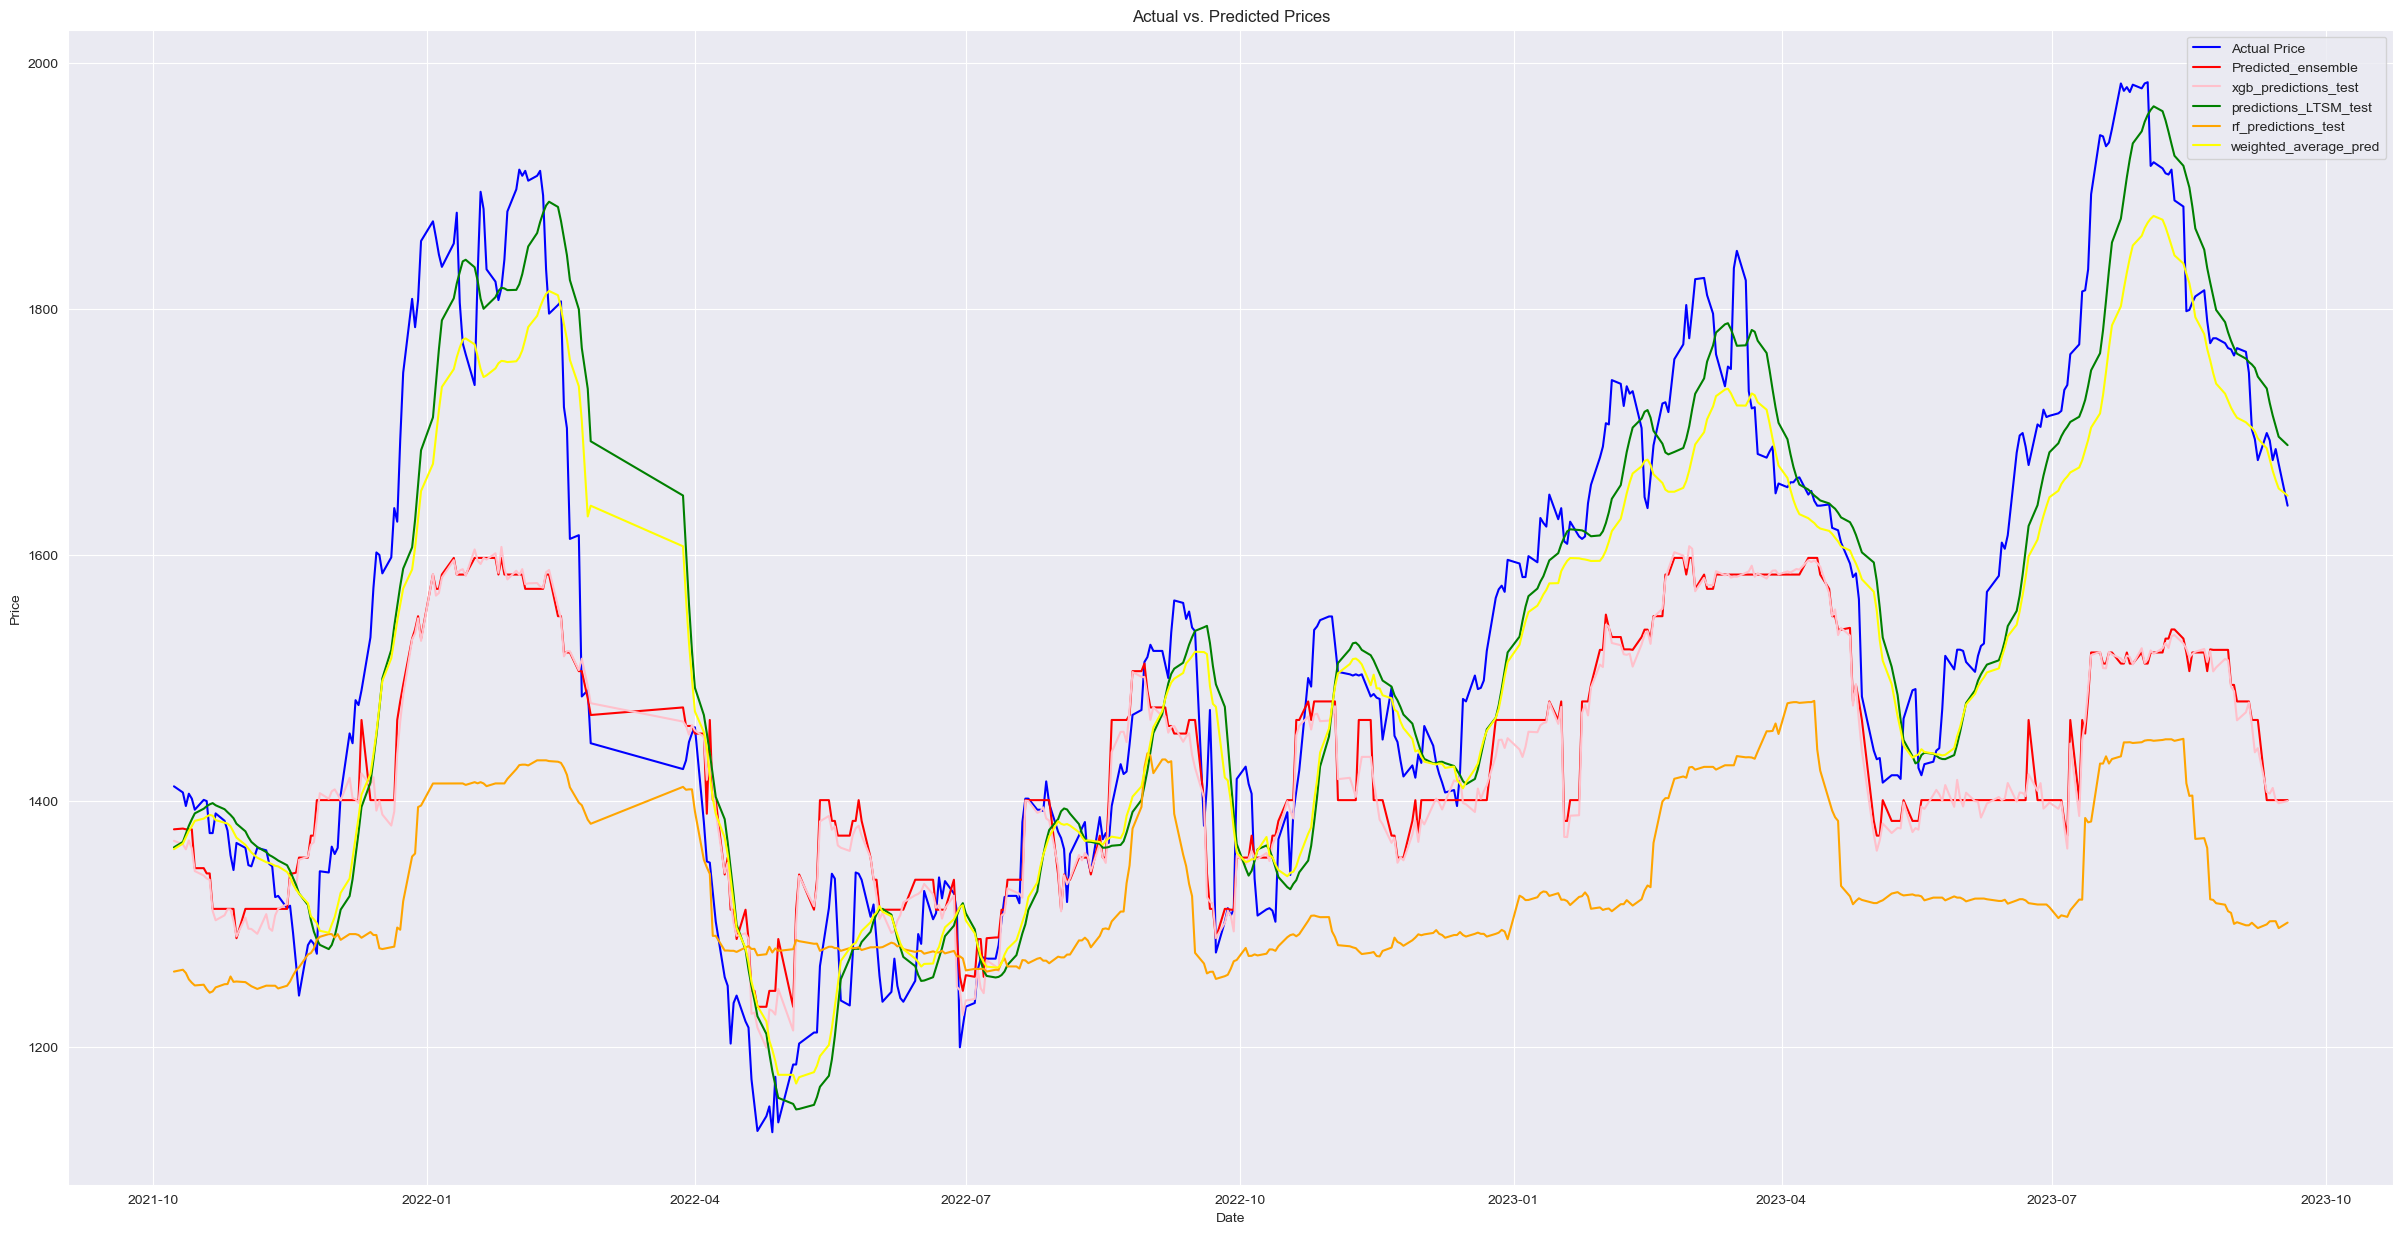

In [295]:
y_test = pd.DataFrame(y_test)
y_test = y_test.reset_index(drop=True)

# Reshape the arrays to be 1-dimensional
xgboost_ensemble_model_pred = np.reshape(xgboost_ensemble_model_pred, (-1,))
predictions_LTSM_test = np.reshape(predictions_LTSM_test, (-1,))
xgb_predictions_test = np.reshape(xgb_predictions_test, (-1,))
rf_predictions_test = np.reshape(rf_predictions_test, (-1,))

results = pd.DataFrame({'Date': data_lkoh['Дата'][train_size+time_steps+1:].reset_index(drop=True),
                        'Actual': y_test['Target'].reset_index(drop=True),
                        'Predicted_ensemble': xgboost_ensemble_model_pred,
                        'predictions_LTSM_test': predictions_LTSM_test,
                        'xgb_predictions_test': xgb_predictions_test,
                        'rf_predictions_test': rf_predictions_test,
                        'weighted_average_pred': weighted_average_pred})


# Plot the graph
plt.figure(figsize=(30, 15))
plt.plot(results['Date'], results['Actual'], label='Actual Price', color='blue')
plt.plot(results['Date'], results['Predicted_ensemble'], label='Predicted_ensemble', color='red')
plt.plot(results['Date'], results['xgb_predictions_test'], label='xgb_predictions_test', color='pink')
plt.plot(results['Date'], results['predictions_LTSM_test'], label='predictions_LTSM_test', color='green')
plt.plot(results['Date'], results['rf_predictions_test'], label='rf_predictions_test', color='orange')
plt.plot(results['Date'], results['weighted_average_pred'], label='weighted_average_pred', color='yellow')
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

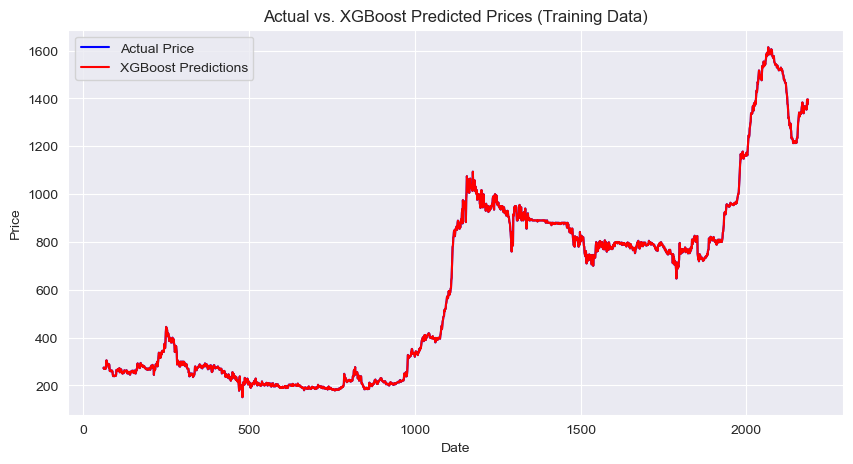

XGBoost Model Metrics:
RMSE (Root Mean Squared Error): 0.34115761276333967
r2 (R-squared): 0.9999992247170956


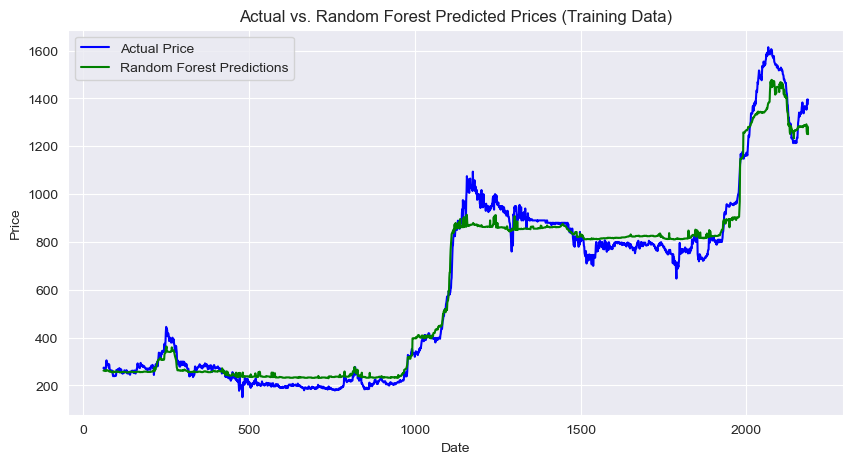

Random Forest Model Metrics:
RMSE (Root Mean Squared Error): 56.802021322317515
r2 (R-squared): 0.9785079592670195


In [286]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Predict using XGBoost model
xgb_predictions_train = model_xgb.predict(X_train)

# Plot the graph for XGBoost predictions
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label='Actual Price', color='blue')
plt.plot(y_train.index, xgb_predictions_train, label='XGBoost Predictions', color='red')
plt.title('Actual vs. XGBoost Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate metrics for XGBoost model
mse_xgb = mean_squared_error(y_train, xgb_predictions_train)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_train, xgb_predictions_train)

print('XGBoost Model Metrics:')
print('RMSE (Root Mean Squared Error):', rmse_xgb)
print('r2 (R-squared):', r2_xgb)

# Predict using Random Forest model
rf_predictions_train = model_rf.predict(X_train)

# Plot the graph for Random Forest predictions
plt.figure(figsize=(10, 5))
plt.plot(y_train.index, y_train, label='Actual Price', color='blue')
plt.plot(y_train.index, rf_predictions_train, label='Random Forest Predictions', color='green')
plt.title('Actual vs. Random Forest Predicted Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculate metrics for Random Forest model
mse_rf = mean_squared_error(y_train, rf_predictions_train)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_train, rf_predictions_train)

print('Random Forest Model Metrics:')
print('RMSE (Root Mean Squared Error):', rmse_rf)
print('r2 (R-squared):', r2_rf)